In this script I use the RFM model in order to have a deterministic description of the value of the each customer through some metrics:
*   Recency -> Time from the last purchase
*   Frequency -> How often the customer purchase
*   Monetary -> How much money he spends

This model offers different points of view of the customer
behaviour. Consequently it helps the business in order to take decisions.



# RFM




I import the libraries and the dataset I need. It contains information about the customer_id and the order that he made.

In [ ]:
import pandas as pd
import numpy as np
import csv
from google.colab import drive
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')
data=pd.read_csv("/content/gdrive/MyDrive/customer_orders.csv")

Mounted at /content/gdrive


In [ ]:
# I consider only some columns
rfm=data[['customer_id','order_id','purchase_datetime','gross_price','price_reduction',"direction"]]


I consider only the purchase actions.

In [ ]:
rfm=rfm[rfm.direction==1]

 Initially, to understand the behaviour of the customers I determine the repurchase curve in a way that  the 90% of the customer repurchase within this time interval.

In [ ]:
# I convert the column purchase_datetime in a date format
rfm['purchase_datetime'] = pd.to_datetime(rfm['purchase_datetime'])

# I group by customer_id and purchase date
rfm['Purchase_Date'] = rfm.groupby(['customer_id', rfm['purchase_datetime'].dt.date]).cumcount() + 1
rfm = rfm.drop_duplicates(subset=['customer_id', 'Purchase_Date'], keep='first')


In [ ]:
# I calculate the difference in days between two subsequent purchases made by a costumer
rfm['Differenza_Giorni'] = rfm.groupby('customer_id')['purchase_datetime'].diff().dt.days

# I compute the mean between these differences for each costumer
media_differenze = rfm.groupby('customer_id')['Differenza_Giorni'].mean()


I delete the 0's[who have made different orders in a single day] and the Nan values[who have made only an order]

In [ ]:
media_differenze=media_differenze[media_differenze>0]

I analyze the repurchase curve in order to evaluate the average days to next purchase for the customers.

In [ ]:
# I  define a function to calculate the empirical cumulative distribution function (ECDF)
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y

#ECDF
x, y = ecdf(media_differenze)

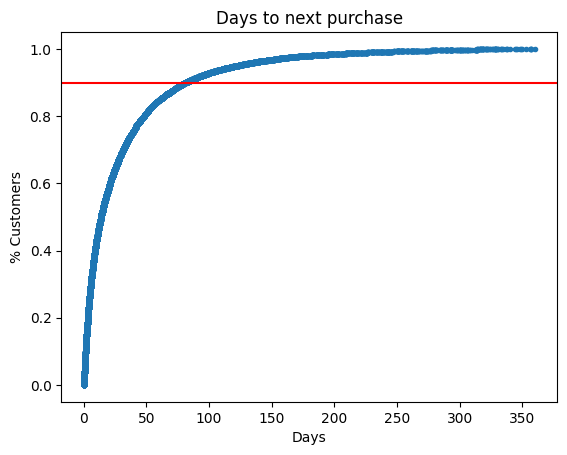

Quantile al 90%: 81.15000000000055


In [ ]:
# Plot ECDF
plt.plot(x, y, marker='.', linestyle='none')
plt.title('Days to next purchase')
plt.xlabel('Days')
plt.ylabel('% Customers')

# a line to identify the 0.9 of costumers
plt.axhline(y=0.9, color='r', linestyle='-')

plt.show()

# quantile at 90%
quantile_90 = np.percentile(media_differenze[media_differenze>0], 90)
print("Quantile al 90%:", quantile_90)


Above the 90% of the customers purchase a second time after 82 days.

A fundamental point in the RFM model is to make
the distinction between active and inactive customers, the ones that do not purchase for a long time. This is necessary since the RFM model is focused on the behaviour of the active customers.

The first datetime in the orders dataset is 2022-05-01.
Consequently the customers who did not purchase in the range (2022-05-01, 2023-04-30) have been classified as non active customers, thus removed since the RFM model is focused on active customers.
Consequently the customers that have not made any purchase after this date have been discarded.

In [ ]:
from datetime import datetime
# I compute the total expenditure grouping by customer_id,order_id and purchase_datetime
rfm_new = rfm.groupby(['customer_id', 'order_id', 'purchase_datetime']).agg({'gross_price': sum, 'price_reduction': sum}).reset_index()
rfm_new['SPESA'] = rfm_new['gross_price'] - rfm_new['price_reduction']
rfm_new['purchase_datetime'] = pd.to_datetime(rfm_new['purchase_datetime'])

In [ ]:
# I discarde the inactive customer (who have not made purchase after 2022-05-01)
data_max = data[['customer_id', 'purchase_datetime']].groupby('customer_id').max().reset_index()
data_max.columns = ['customer_id', 'ULTIMA_DATA']
data_max['ULTIMA_DATA'] = pd.to_datetime(data_max['ULTIMA_DATA'])
data_max = data_max[data_max['ULTIMA_DATA'] >= datetime.strptime('2022-05-01', '%Y-%m-%d')]


In [ ]:
data_max

,customer_id,ULTIMA_DATA
0,23,2023-02-20 11:51:51
1,30,2022-07-23 07:06:38
2,32,2023-04-02 15:11:58
3,48,2023-04-30 19:35:36
4,50,2023-02-19 16:56:32
...,...,...
102817,934484,2023-04-30 19:02:11
102818,934581,2023-04-30 19:35:53
102819,934620,2023-04-30 19:19:55
102820,934660,2023-04-30 19:32:17


This new version of the dataset consider only the active customers.

In [ ]:
rfm_new = pd.merge(rfm_new, data_max, on='customer_id')


In [ ]:
rfm_new

,customer_id,order_id,purchase_datetime,gross_price,price_reduction,SPESA,ULTIMA_DATA
0,23,23,2022-10-04 18:28:51,216.84,0.00,216.84,2023-02-20 11:51:51
1,23,23,2022-10-31 13:07:42,58.88,5.89,52.99,2023-02-20 11:51:51
2,23,23,2022-12-06 12:26:21,13.74,0.00,13.74,2023-02-20 11:51:51
3,30,30,2022-06-11 18:41:54,3.10,0.31,2.79,2022-07-23 07:06:38
4,30,30,2022-07-23 07:06:38,1173.04,49.39,1123.65,2022-07-23 07:06:38
...,...,...,...,...,...,...,...
156393,934484,934484,2023-04-30 19:02:11,39.10,4.09,35.01,2023-04-30 19:02:11
156394,934581,934581,2023-04-30 19:35:53,33.60,0.00,33.60,2023-04-30 19:35:53
156395,934620,934620,2023-04-30 19:19:55,21.98,0.00,21.98,2023-04-30 19:19:55
156396,934660,934660,2023-04-30 19:32:17,1.90,0.00,1.90,2023-04-30 19:32:17


I define a function to calculate the RFM score.
It works as follows:


*   It takes in input the dataset(information about each customers) and the number recency,frequency and monetary bins in order to assign the customer to a determinated bin
*  For each customer they are computed measures like his expense, the number of orders he made and the date of the last order. These operations are necessary in order to create the three metrics:Recency, Frequency and Monetary.

* It creates the bins based on the values of the three measures


In [ ]:
# Function to compute the RFM score
def rfm_table_order(data, customer_id, revenue, order_date, analysis_date, recency_bins, frequency_bins, monetary_bins):
    recency_labels = list(range( recency_bins,0,-1))
    #recency_labels = list(range(1,recency_bins+1))

    frequency_labels =list(range(1, frequency_bins))
    monetary_labels = list(range(1, monetary_bins+1))

    data['Recency'] = (analysis_date-data[order_date]).dt.days
    rfm = data.groupby(customer_id).agg({
        'Recency': 'min',
        revenue: 'sum',
        order_date: 'count'
    }).reset_index()

    rfm.columns = [customer_id, 'Recency', 'Monetary', 'Frequency']

    rfm['R'] = pd.qcut(rfm['Recency'], recency_bins, labels=recency_labels,duplicates="drop")

    for index, row in rfm.iterrows():
     if row['Frequency'] in [1]:
       rfm.at[index, 'F'] = int(1)
     elif row['Frequency'] in [2]:
       rfm.at[index, 'F'] = int(2)
     else:
       rfm.at[index, 'F'] = int(3)

    rfm['M'] = pd.qcut(rfm['Monetary'], monetary_bins, labels=monetary_labels,duplicates="drop")

    rfm['RFM_Score'] = rfm['R'].astype(np.int8) + rfm['F'].astype(np.int8) + rfm['M'].astype(np.int8)
    return rfm


I have fixed the number of bins equal to 3 for the three quantities.
I use 2023-07-06 as the analysis date, in order to compute the recency indicator.

In [ ]:
# RFM score
rfm_result = rfm_table_order(
    data=rfm_new,
    customer_id='customer_id',
    revenue='SPESA',
    order_date='purchase_datetime',
    analysis_date=datetime.strptime('2023-07-06', '%Y-%m-%d'),
    recency_bins=3,
    frequency_bins=3,
    monetary_bins=3
)


In [ ]:
rfm_result

,customer_id,Recency,Monetary,Frequency,R,F,M,RFM_Score
0,23,211,283.57,3,2,3.0,3,8
1,30,347,1126.44,2,1,2.0,3,6
2,32,94,41.53,3,3,3.0,2,8
3,48,188,528.11,5,3,3.0,3,9
4,50,168,15.34,1,3,1.0,2,6
...,...,...,...,...,...,...,...,...
102817,934484,66,35.01,1,3,1.0,2,6
102818,934581,66,33.60,1,3,1.0,2,6
102819,934620,66,21.98,1,3,1.0,2,6
102820,934660,66,1.90,1,3,1.0,1,5


I define the limts to define the classes:[One-Timer,Leaving, Engaged, Leaving Top, Top] that describe the  customers loyalty statuses.

In [ ]:
# Class and limits definition
classes = ['One-Timer', 'Leaving', 'Engaged', 'Leaving Top', 'Top']
recency_lower=[2,1,2,1,2]
recency_upper=[3,1,3,1,3]
frequency_lower=[1,1,2,3,3]
frequency_upper=[1,2,2,3,3]
monetary_lower=[1,1,1,1,1]
monetary_upper=[3,3,3,3,3]

# Creation of the dataset rfm_classes in order to create the column segment
# in the original dataset

new_data = {'segment': classes, 'recency_lower': recency_lower, 'recency_upper': recency_upper,
        'frequency_lower': frequency_lower, 'frequency_upper': frequency_upper,
        'monetary_lower': monetary_lower, 'monetary_upper': monetary_upper}
rfm_classes = pd.DataFrame(new_data)

# Function to assign the class category to each row in the original dataset
def assign_class(row):
    for i, class_row in rfm_classes.iterrows():
        if (class_row['recency_lower'] <= row['R']) and (row['R'] <= class_row['recency_upper']):
            if (class_row['frequency_lower'] <= row['F']) and (row['F'] <= class_row['frequency_upper']):
                if (class_row['monetary_lower'] <= row['M']) and (row['M'] <= class_row['monetary_upper']):
                    return class_row['segment']
    return None

# Adding the results of the function previously defined
rfm_result['segment'] = rfm_result.apply(assign_class, axis=1)



In [ ]:
rfm_result

,customer_id,Recency,Monetary,Frequency,R,F,M,RFM_Score,segment
0,23,211,283.57,3,2,3.0,3,8,Top
1,30,347,1126.44,2,1,2.0,3,6,Leaving
2,32,94,41.53,3,3,3.0,2,8,Top
3,48,188,528.11,5,3,3.0,3,9,Top
4,50,168,15.34,1,3,1.0,2,6,One-Timer
...,...,...,...,...,...,...,...,...,...
102817,934484,66,35.01,1,3,1.0,2,6,One-Timer
102818,934581,66,33.60,1,3,1.0,2,6,One-Timer
102819,934620,66,21.98,1,3,1.0,2,6,One-Timer
102820,934660,66,1.90,1,3,1.0,1,5,One-Timer


At the end on the basis of the values previously computed, the class that are defined are:[Diamond, Gold, Silver, Bronze, Copper, Tin].
This is done thanks to the value of the Monetary indicates that allows the division in these other segments.

In [ ]:
#  labels: Diamond, Gold, Silver, Bronze, Copper, Tin
label = []
for i, row in rfm_result.iterrows():
    if row['segment'] == 'One-Timer':
        if row['M'] == 1:
            label.append('Cheap')
        elif row['M'] == 2:
            label.append('Tin')
        else:
            label.append('Copper')
    elif row['segment'] == 'Leaving':
        if row['M'] == 1:
            label.append('Tin')
        elif row['M'] == 2:
            label.append('Copper')
        else:
            label.append('Bronze')
    elif row['segment'] == 'Engaged':
        if row['M'] == 1:
            label.append('Copper')
        elif row['M'] == 2:
            label.append('Bronze')
        else:
            label.append('Silver')
    elif row['segment'] == 'Leaving Top':
        if row['M'] == 1:
            label.append('Bronze')
        elif row['M'] == 2:
            label.append('Silver')
        else:
            label.append('Gold')
    elif row['segment'] == 'Top':
        if row['M'] == 1:
            label.append('Silver')
        elif row['M'] == 2:
            label.append('Gold')
        else:
            label.append('Diamond')
rfm_result['result']=label


Plot of the number of customers for each category

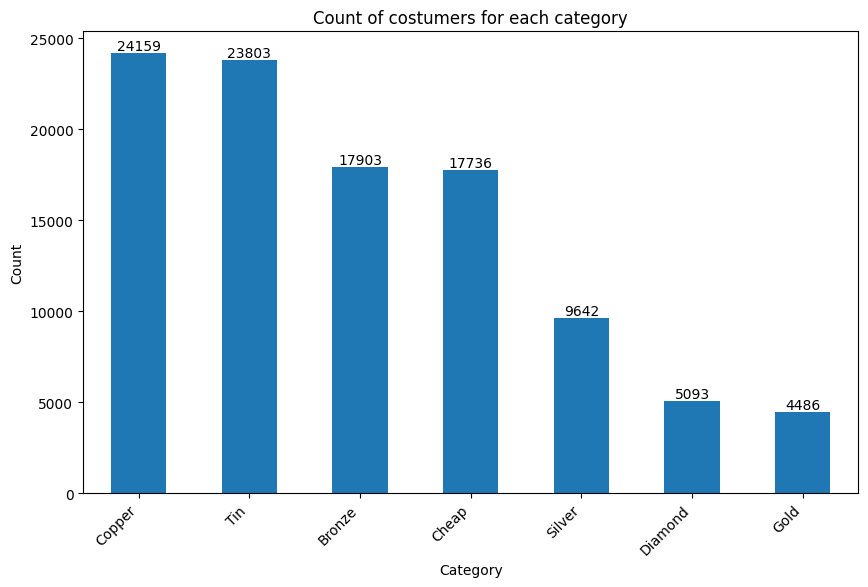

In [ ]:
class_counts = rfm_result['result'].value_counts()

plt.figure(figsize=(10, 6))


class_counts.plot(kind='bar')

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of costumers for each category')

plt.xticks(rotation=45, ha='right')
for i, v in enumerate(class_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()


As we can see most of the customers belong to the class Copper and Tin, while the classes:Silver,Diamond and Gold represent the 23% of the total.

I plot the median monetary value for each category

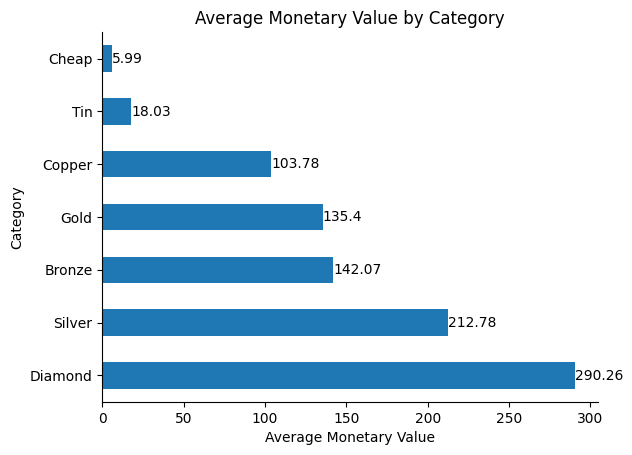

In [ ]:
df_groups = rfm_result.groupby(['result'])['Monetary'].mean()
df_sorted = df_groups.sort_values(ascending=False)
ax = df_sorted.plot(kind='barh')  # Get the Axes object

# Customize the plot using the Axes object
ax.set_xlabel('Average Monetary Value')
ax.set_ylabel('Category')
ax.set_title('Average Monetary Value by Category')

# Add value annotations to the bars
for i, v in enumerate(df_sorted.values):
    ax.text(v, i, str(round(v, 2)), ha='left', va='center')
ax.spines[['right', 'top']].set_visible(False)

# Display the plot
plt.show()



The Diamond Category is the one with the highest monetary value. It is curious that the Gold customers present an average monetary value lower than the other categories. Probably these customers purchase inexpensive products with high frequency.